# **Heart rate estimation project**
### by Erica Brisigotti, Ekaterina Chueva & Nadillia Saphutra

## 0. **Introduction**

With modern sensors it is possible to construct wearable devices that can track heart rhythm in real time. These devices can use different approaches, such as electrocardiography (ECG), ballistocardiography (BCG), seismocardiography (SCG), and gyrocardiography (GCG) [1].

In this project we work with data collected by an Inertial Measurement Unit (IMU) called MuSe (by 221e). This device can track both linear and angular vibrations (resulting in seismocardiographic an gyrocardiographic waves), which provide information on heart’s mechanical activity.


In the first dataset a SCG/GCG method was used and the IMU was attached to the human's chest. An analagous example is shown in the picture below.

In [1]:
# from IPython.display import Image
# Image("SCG_sensor.png")

Heart's cardio-mechanical activities can be represented by linear (SCG) and angular (GCG) vibrations caused by the ventricular contractions [2]. This signal is different from well-known ECG signal, which can be observed in the following picture.

In [2]:
# Image("ECG_SCG.png")

In the second dataset accquiring the BCG method was used. The contact with a body is not required, because in this method sensors measure the recoil forces of the whole body, not only the chest [2].

Literature:
    
[1] Efficient detection of aortic stenosis using morphological characteristics of cardiomechanical signals and heart rate variability parameters. Arash Shokouhmand et al. 2021

[2] A real-time approach for heart rate monitoring using a Hilbert transform in seismocardiograms. Mojtaba Jafari Tadi et al. 2016.

[3] Discrete Wavelet Transforms‐Based Analysis of Accelerometer Signals for Continuous Human Cardiac Monitoring. Hany Ferdinando, Eveliina Seppälä, Teemu Myllylä. 2021

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import fftpack, stats, signal
from scipy.optimize import curve_fit
import scipy.linalg as la
import pywt

## 1. **Data preparation**

### 1.1 **Selecting columns + accounting for offsets**

Even before uploading the data, it is well-known that there are 16 columns with different variables. Specifically:
* **Log Freq** stands for the acquisition  in Hz (i.e., sampling interval is constant).
* **AccX, AccY, AccZ** are the measured magnitude of linear acceleration along each axis.
* **GyroX, GyroY, GyroZ** are the measured magnitude of angular velocity along each axis.
* **MagnX, MagnY, MagnZ** are the measured magnitude of magnetic field along each axis.
* **qw, qi, qj, qk** are the quaternion components, representing the spatial orientation of the Muse system.

From the literature available on the topic the techniques  to be implemented only analyse the evolution in time of linear accelleration and angular momentum. Therefore, only accelerometer, gyrometer and time measurements will be needed. The other physical quantities can be discarded.

Such statements are supported by the data, which is uploaded (as a Pandas' dataframe) and statistically analyzed through the appropriate Pandas' built-in function (<a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html"> <code>pandas.describe</code> </a>).

In [4]:
file_name = 'center_sternum.txt'
just_uploaded = pd.read_csv(file_name, delimiter='\t')
all_data = pd.DataFrame(just_uploaded)
display(all_data)
all_data.describe()

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126,0.650810,0.379162,-0.636402,0.166356
16502,5,200,1576222847,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125,0.650239,0.379803,-0.636708,0.165960
16503,5,200,1576222847,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125,0.649365,0.380627,-0.637227,0.165502
16504,5,200,1576222847,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124,0.648973,0.381329,-0.637348,0.164953


,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
count,16506.0,16506.0,1.650600e+04,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000
mean,5.0,200.0,1.576223e+09,35.603752,121.754422,-897.001465,-1.885665,3.636535,-0.818354,-231.327881,-432.637405,397.903005,0.063803,0.490530,-0.764329,-0.039947
std,0.0,0.0,2.189258e+01,232.624330,62.077114,215.230574,13.223364,17.399954,10.595643,67.200320,16.526077,123.871453,0.144073,0.197328,0.326346,0.057694
min,5.0,200.0,1.576223e+09,-722.118000,-387.838000,-1731.973000,-359.496200,-213.557300,-126.351100,-511.000000,-559.000000,-178.000000,0.004428,-0.622059,-0.892911,-0.096347
25%,5.0,200.0,1.576223e+09,-35.258000,111.020000,-958.310000,-2.839695,3.206107,-1.175573,-213.000000,-434.000000,427.000000,0.021518,0.493858,-0.859676,-0.060732
50%,5.0,200.0,1.576223e+09,-29.585000,115.900000,-948.733000,-2.137405,3.664122,-0.854962,-212.000000,-432.000000,429.000000,0.024636,0.529649,-0.836619,-0.059511
75%,5.0,200.0,1.576223e+09,-22.692000,120.475000,-937.692000,-1.206107,4.213740,-0.549618,-211.000000,-431.000000,433.000000,0.027304,0.564768,-0.813227,-0.057619
max,5.0,200.0,1.576223e+09,1228.601000,1004.609000,3087.000000,381.160300,349.816800,187.603100,-130.000000,-289.000000,481.000000,0.792622,0.624806,0.921293,0.251900


The brief descriptive statistics provided by the <code>pandas.describe</code> function are particularly helpful in getting the time at which every measurement has been taken.
The **Log Freq** data, which represents the acquisition rate (in Hz), is constant and therefore allows for straigh-forward identification of the time interval between two successive measurements.

In [5]:
freq = all_data['Log Freq'].unique()[0] # Hz
time = np.arange(0,(len(all_data.index)/freq),(1/freq)) # seconds

This new time notation is adopted to substitute the "Timestamp" column, which is ambiguous because of its repetitive values.

The new notation simply consists of a vector with increasing values of time, representing the instant at which the corresponding measurements are taken.

All unnecessary columns can now be dropped: at the same time, a new column is added to store the new time variable.

In [6]:
data = all_data.drop(['MagnX','MagnY','MagnZ','qw','qi','qj','qk','Log Mode','Log Freq','Timestamp'], axis = 1)
data.insert(0, "Time", time)
data #.describe()

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,0.000,947.086,435.662,70.638,-6.824428,-14.244280,1.404580
1,0.005,969.168,387.777,88.877,6.183206,-12.290080,-7.969466
2,0.010,989.603,380.335,78.751,11.709920,-4.961832,-7.450382
3,0.015,954.894,418.033,88.328,17.877860,2.519084,-5.984733
4,0.020,972.096,427.732,99.857,25.221370,5.404580,4.015267
...,...,...,...,...,...,...,...
16501,82.505,958.493,291.092,-54.290,1.664122,2.305344,-0.671756
16502,82.510,954.650,288.042,-49.654,1.480916,2.488550,-0.702290
16503,82.515,967.338,290.482,-63.867,1.114504,3.374046,-0.900763
16504,82.520,965.630,300.852,-56.242,0.702290,3.664122,-1.587786


Then offsets are taken from the 'README1' file (corresponds to "center_sternum" dataset) and added to the corresponding variables:

In [7]:
acc_offsets = np.array([-3.929942, -13.7467, 60.67546])

data['AccX'] += acc_offsets[0]
data['AccY'] += acc_offsets[1]
data['AccZ'] += acc_offsets[2]


data.describe()

,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
count,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000,16506.000000
mean,41.262500,31.673810,108.007722,-836.326005,-1.885665,3.636535,-0.818354
std,23.825081,232.624330,62.077114,215.230574,13.223364,17.399954,10.595643
min,0.000000,-726.047942,-401.584700,-1671.297540,-359.496200,-213.557300,-126.351100
25%,20.631250,-39.187942,97.273300,-897.634540,-2.839695,3.206107,-1.175573
50%,41.262500,-33.514942,102.153300,-888.057540,-2.137405,3.664122,-0.854962
75%,61.893750,-26.621942,106.728300,-877.016540,-1.206107,4.213740,-0.549618
max,82.525000,1224.671058,990.862300,3147.675460,381.160300,349.816800,187.603100


### 1.2 **representing the columns + selecting an appropriate time-window**

The columns are devided into two groups based on their physical quantity (linear acceleration and angular velocity). Their evolution in time is represented below.



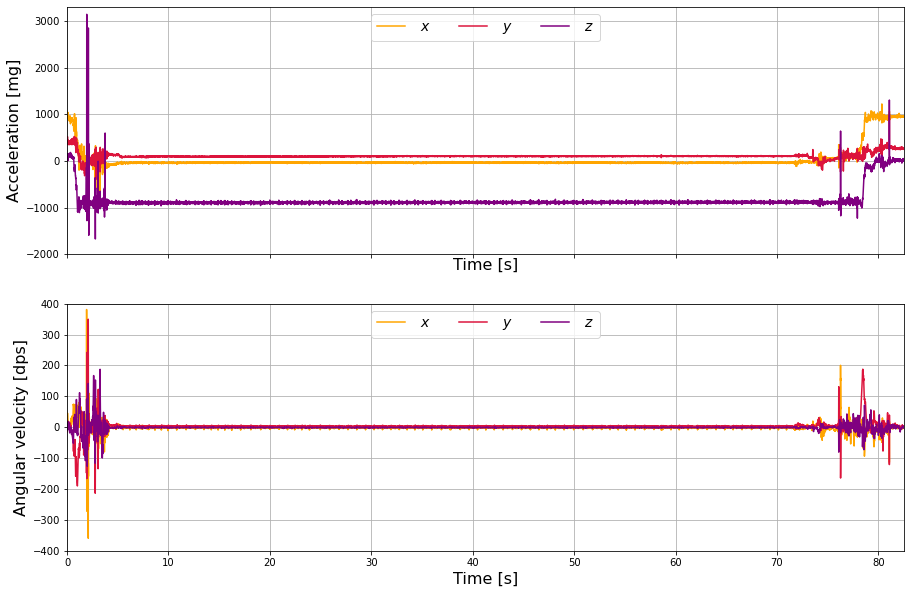

In [8]:
fig1 , ax1 = plt.subplots( nrows = 2 , ncols = 1 , sharex = True , figsize = (15, 10))

ax1[0].plot( data['Time'] , data['AccX'] , '-' , label=' $x$ ' , color='orange' )
ax1[0].plot( data['Time'] , data['AccY'] , '-' , label=' $y$ ' , color='crimson' )
ax1[0].plot( data['Time'] , data['AccZ'] , '-' , label=' $z$ ' , color='purple' )
ax1[0].set_xlim( 0 , data['Time'].max() )
ax1[0].set_ylim( -2000 , 3300 )
ax1[0].set_xlabel( 'Time [s]' , fontsize = 16 )
ax1[0].set_ylabel( 'Acceleration [mg]' , fontsize = 16 )
ax1[0].legend( loc='upper center' , fontsize = 14 , ncol = 3 )
ax1[0].grid()

ax1[1].plot( data['Time'] , data['GyroX'] , '-' , label = ' $x$ ' , color='orange' )
ax1[1].plot( data['Time'] , data['GyroY'] , '-' , label = ' $y$ ' , color='crimson' )
ax1[1].plot( data['Time'] , data['GyroZ'] , '-' , label = ' $z$ ' , color='purple' )
ax1[1].set_xlim( 0 , data['Time'].max() )
ax1[1].set_ylim( -400 , 400 )
ax1[1].set_xlabel( 'Time [s]' , fontsize = 16 )
ax1[1].set_ylabel( 'Angular velocity [dps]' , fontsize = 16 )
ax1[1].legend( loc='upper center' , fontsize = 14  , ncol = 3 )
ax1[1].grid()


A few observations come up from a graphical representation of the data:
- all columns follow a similar trend, which consists of small obscillations around an offset for the majority of time and some larger fluctuations at the beginning and the end of each column
- if the larger fluctuations were caused by the heartbeat, the patient's heart wouldn't beat for over a minute (would be dead) which is paradoxical: it follows that the interesting, heart-rate related information is be contained in the innermost, small obscillating portion of each set of measurement
- the larger fluctuations at the beginning and at the end of each variable are therefore regarded as anomalies (i.e. to be discarded), possibly due to the patient positioning himself or the devices being set up for the measurements

A more quantitative approach to the selection of the data is based on the standard deviation for each column.
The algorithm starts from the center of the dataset, takes increasingly wider subsets of each column and calculates the corresponding standard deviation.
    
To allow for a more intuitive graphical representation, this algorythm depends only on one variable: in ordert to do that, each interval starts or ends at the center of the vector. Consequently, their shape is either

$$[a,\tfrac{1}{2}l] \wedge a<\tfrac{1}{2}l \;\; \text{or} \;\; [\tfrac{1}{2}l,b] \wedge b>\tfrac{1}{2}l$$

where $l$ is the length of the vector.

The selection of an appropriate time window is then made based on the evolution of standard deviation.

In [9]:
def std_from_center( vect ):
    vect = np.array( vect )
    center_idx = int( vect.shape[0]/2 )
    std_down = [ np.std(vect[ (center_idx-idx):center_idx ] ) for idx in range(1,center_idx,1) ] 
    std_up = [ np.std( vect[ center_idx:(center_idx+idx) ] ) for idx in range(1,center_idx,1) ] 
    return np.concatenate((std_down[::-1],std_up))

the percentage of measurements to keep is  78.75923906458257


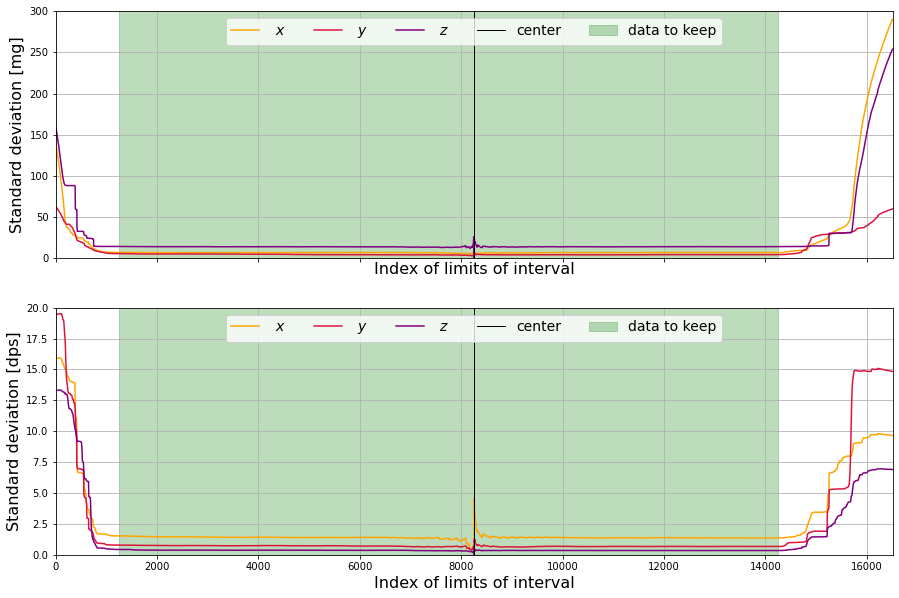

In [10]:
fig2,ax2 = plt.subplots( nrows = 2 , ncols = 1 , sharex = True , figsize = ( 15 , 10 ) )
center_idx = int( data.shape[0]/2 )
down_cut = 7000
up_cut = 6000

print('the percentage of measurements to keep is ', (down_cut+up_cut)/data.shape[0]*100)
down_idx = center_idx-down_cut
up_idx = center_idx+up_cut
down_limit = ( data['Time'] )[ down_idx ]
up_limit = ( data['Time'] )[ up_idx ]


ax2[0].plot( std_from_center( data['AccX']) , '-' , label = ' $x$ ' , color='orange' )
ax2[0].plot( std_from_center( data['AccY']) , '-' , label = ' $y$ ' , color='crimson' )
ax2[0].plot( std_from_center( data['AccZ']) , '-' , label = ' $z$ ' , color='purple' )
ax2[0].axvline( x = center_idx , linestyle = '-' , color = 'k' , label = 'center' , linewidth = 1 )
ax2[0].fill_betweenx( y = [0,300] , x1 = down_idx , x2 = up_idx , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax2[0].set_xlim( 0 , data.shape[0] )
ax2[0].set_ylim( 0 , 300 )
ax2[0].set_xlabel( 'Index of limits of interval' , fontsize = 16 )
ax2[0].set_ylabel( 'Standard deviation [mg]' , fontsize = 16 )
ax2[0].legend( loc = 'upper center' , ncol = 5 , fontsize = 14 )
ax2[0].grid()

ax2[1].plot( std_from_center( data['GyroX']) , '-' , label = ' $x$ ' , color='orange' )
ax2[1].plot( std_from_center( data['GyroY']) , '-' , label = ' $y$ ' , color='crimson' )
ax2[1].plot( std_from_center( data['GyroZ']) , '-' , label = ' $z$ ' , color='purple' )
ax2[1].axvline( x = center_idx , linestyle = '-' , color = 'k' , label = 'center' , linewidth = 1 )
ax2[1].fill_betweenx( y = [0,20] , x1 = down_idx, x2 = up_idx , color='forestgreen' , alpha = 0.3 , label='data to keep' )
ax2[1].set_xlim( 0 , data.shape[0] )
ax2[1].set_ylim( 0 , 20 )
ax2[1].set_xlabel( 'Index of limits of interval' , fontsize = 16 )
ax2[1].set_ylabel( 'Standard deviation [dps]' , fontsize = 16 )
ax2[1].legend( loc = 'upper center' , ncol = 5 , fontsize = 14 )
ax2[1].grid()

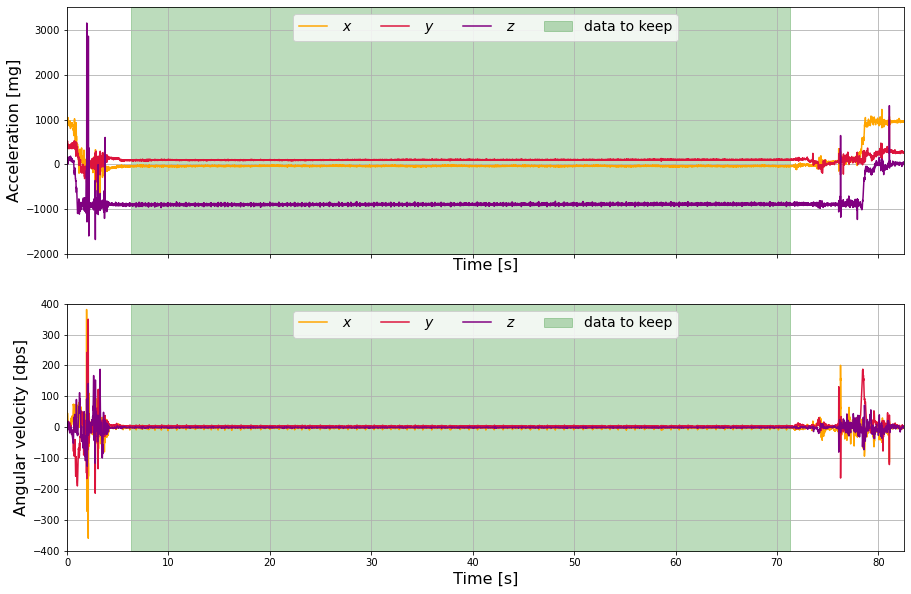

In [11]:
fig3, ax3 = plt.subplots( nrows = 2 , ncols = 1 , sharex = True , figsize = ( 15 , 10 ) )

ax3[0].plot( data['Time'] , data['AccX'] , '-' , label = ' $x$ ' , color = 'orange' )
ax3[0].plot( data['Time'] , data['AccY'] , '-' , label = ' $y$ ' , color = 'crimson' )
ax3[0].plot( data['Time'] , data['AccZ'] , '-' , label = ' $z$ ' , color = 'purple' )
ax3[0].fill_betweenx( y = [-2000,+3500] , x1 = down_limit , x2 = up_limit , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax3[0].set_xlim( min(data['Time']) , max(data['Time']) )
ax3[0].set_ylim( -2000 , +3500 )
ax3[0].set_xlabel( 'Time [s]' , fontsize = 16 )
ax3[0].set_ylabel( 'Acceleration [mg]' , fontsize = 16 )
ax3[0].legend( loc = 'upper center' , ncol = 4 , fontsize = 14 )
ax3[0].grid()

ax3[1].plot( data['Time'] , data['GyroX'] , '-' , label = ' $x$ ' , color='orange' )
ax3[1].plot( data['Time'] , data['GyroY'] , '-' , label = ' $y$ ' , color='crimson' )
ax3[1].plot( data['Time'] , data['GyroZ'] , '-' , label = ' $z$ ' , color='purple' )
ax3[1].fill_betweenx( y=[ -400 , +400 ] , x1=down_limit , x2 = up_limit , color='forestgreen' , alpha =0.3 , label = 'data to keep' )
ax3[1].set_xlim( min( data['Time'] ) , max( data['Time'] ) )
ax3[1].set_ylim( -400, +400 )
ax3[1].set_xlabel( ' Time [s] ' , fontsize = 16 )
ax3[1].set_ylabel( ' Angular velocity [dps] ', fontsize = 16 )
ax3[1].legend( loc = 'upper center' , ncol = 4 , fontsize = 14 )
ax3[1].grid()

The data corresponding to the outside of such window is dropped and the indexes of are adjusted to compensate for the cut.

In [12]:
ok_data = data.copy()
ok_data.drop( data[ data['Time'] <= down_limit ].index, inplace=True)
ok_data.drop( data[ data['Time'] >= up_limit ].index, inplace=True)
ok_data.set_index( np.arange(len(ok_data) ),inplace=True)

### 1.3 **PCA + choosing an appropriate combination of columns**

Before going further into the analysis, the underlying structure of the variables must be investigated. Two key factors must included in this process:
   - firstly, one or more of the columns could contain redundant information or small variations compared to the others: to identify both instances, a Principal Component Analysis is implemented: it returns the percentages of variation corresponding to each column, based on which we're able to deduct the ones to keep.
   - secondly, if more than one column is to be kept, a useful way to simplify the analysis consists of taking a combination of such columns.

These two steps were executed in parallel based on the physical quantity they represent.
    
Lastly, a further semplification of the future analysis follows from similar examples in literature [1]: the two physical quantities can be normalized and summed together.

In [13]:
def PCA_pairplot( vect ):
    # sns.pairplot( vect , height = 2)
    vect_cov = np.cov( vect.T )
    vect_val , vect_vect = la.eig( vect_cov )
    vect_val = np.real_if_close( vect_val )
    perc = vect_val*100/vect_val.sum()
    return perc

#### 1.3.1 **PCA on acceleration**

In [14]:
print( 'the percentages corresponding the components of the acceleration are ' , PCA_pairplot( ok_data[ ['AccX','AccY','AccZ'] ] ) )

the percentages corresponding the components of the acceleration are  [76.01651084 13.89802654 10.08546262]


#### 1.3.2 **PCA on angular velocity**

In [15]:
print( 'the percentages corresponding the components of the angular velocity are ' , PCA_pairplot( ok_data[ ['GyroX','GyroY','GyroZ'] ] ) )

the percentages corresponding the components of the angular velocity are  [79.8902901  15.99083415  4.11887575]


#### 1.3.3 **Combining columns**

None of the columns can be discarded since all the corresponding percentages are non-negligible. On the other hand, they can be combined into a single variable to simplify future analysis. 

The most straightforward approach consists of switching from a Carthesian to a polar set of coordinates

$$ \vec{v} \rightarrow \left(\,  x \, , \, y \, , \, z \, \right) \rightarrow \left(\,  \| \vec{v} \| \, , \, \theta \, , \, \phi \, \right) \;\;\; \text{where} \;\;\; \| \vec{v} \| = \sqrt{x^2 + y^2 + z^2} $$

and then taking just the norm $\| \vec{v} \|$ of the physical quantity $\vec{v}$. 

There is no need to switch to the eigenvector basis (from PCA) before calculating the norm $\| \vec{v} \|$ since it is invariant under rotations of the plane around the origin.

In [16]:
acc_norm = np.array( np.sqrt( ok_data['AccX']**2 + ok_data['AccY']**2 + ok_data['AccZ']**2 ))
gyro_norm = np.array( np.sqrt( ok_data['GyroX']**2 + ok_data['GyroY']**2 + ok_data['GyroZ']**2 ))

At the same time, the norms of the vectors can be normalized and summed together, as seen in literature.

In [17]:
time = np.array( ok_data['Time'] )
norm = acc_norm/np.linalg.norm(acc_norm) + gyro_norm/np.linalg.norm(gyro_norm)
to_analyze = pd.DataFrame( { 'Time' : time , 'Norm' : norm })

### 1.4. **Statistical analysis**

A statistical description of the combined dataset is another good measure that can implemented before the analysis.

In [18]:
std_description = pd.concat( [ to_analyze.describe() ,
                            pd.DataFrame( to_analyze.median() , columns=['median'] ).transpose() , 
                            pd.DataFrame( to_analyze.var(), columns=['variance'] ) .transpose() ] )
print(' the median to std ratio is ',
      np.round(std_description['Norm']['median']/std_description['Norm']['std']),':1') 
std_description

 the median to std ratio is  10.0 :1


,Time,Norm
count,12999.000000,12999.000000
mean,38.765000,0.017385
std,18.763162,0.001633
min,6.270000,0.011725
25%,22.517500,0.016505
50%,38.765000,0.017085
75%,55.012500,0.017786
max,71.260000,0.029958
median,38.765000,0.017085
variance,352.056250,0.000003


In [19]:
to_analyze.corr()

,Time,Norm
Time,1.000000,-0.082022
Norm,-0.082022,1.000000


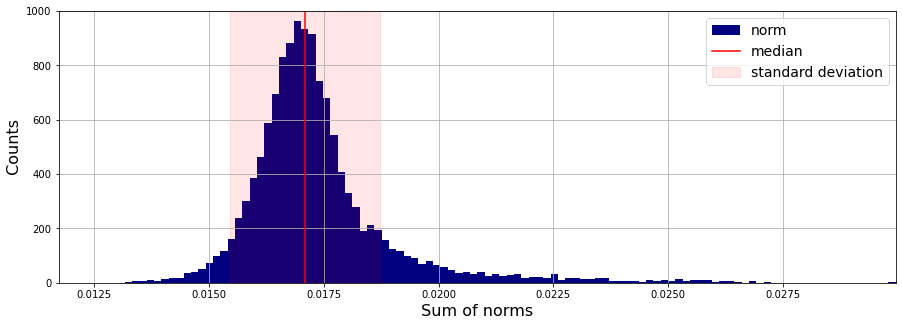

In [20]:
fig5, ax5 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 5 ) )
ax5.hist( norm , bins = int( np.sqrt( len(norm) ) ) , label = 'norm' , color = 'navy' )
ax5.axvline( x = std_description['Norm']['median'] , linestyle = '-' , color = 'r' , label = 'median' )
ax5.fill_betweenx( y=[ 0 , 1000 ] , x1 = (std_description['Norm']['median']-std_description['Norm']['std']) , 
                   x2 = (std_description['Norm']['median']+std_description['Norm']['std']) , 
                   color = 'red' , alpha = 0.1 , label = 'standard deviation' )
ax5.set_xlim( min( norm ) , max( norm ) )
ax5.set_ylim( 0 , +1000 )
ax5.set_xlabel( ' Sum of norms ' , fontsize = 16 )
ax5.set_ylabel( ' Counts ' , fontsize = 16 )
ax5.legend( loc = 'upper right'  , fontsize = 14 )
ax5.grid()
plt.show()

A few observations follow from the statistical descriptors and histogras:
- the distribution is asymmetric, as shown by the difference between the mean and median of <code>Norm</code>
- the distribution already shows a clear peak centered in the median since the median-to-std ratio for <code>Norm</code> is 11:1.

## 2. **Heart-rate estimation through FFT**

The first strategy to calculate heart rate (HR) is Fast Fourier Transform. The algorithm computes the discrete Fourier transform of the signal (in section 2.1), particularly its power. A desired frequency can be identified as the one of the local maxima of the power.

### 2.1 **FFT +  power plot**

In [21]:
def power_fft( vect , timestamp ):
    vect_fft = fftpack.fft( vect )
    vect_power = np.abs( vect_fft )
    vect_all_freq = fftpack.fftfreq( vect.size, d = timestep )
    return vect_fft , vect_power , vect_all_freq

timestep = 1/freq
norm_fft , norm_power , norm_all_freq = power_fft( np.asarray(to_analyze['Norm']) , timestep )

In [22]:
down_freq_lim = 40/60 # Hz
up_freq_lim = 100/60 # Hz

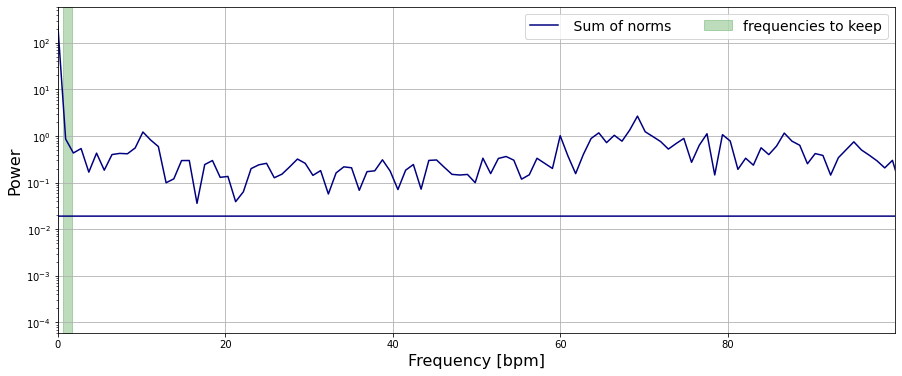

In [23]:
fig6 , ax6 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 6 ) )
ax6.plot( norm_all_freq*60 , norm_power , '-' , label = ' Sum of norms ' , color = 'navy' )
ax6.fill_betweenx( y=[ 10**(-6)*60 , 10**1*60 ], x1 = down_freq_lim , x2 = up_freq_lim , color = 'forestgreen' , alpha = 0.3 , label = 'frequencies to keep' )
ax6.set_xlim(0, max( norm_all_freq ) )
ax6.set_ylim( 10**(-6)*60 , 10**1*60 )
ax6.set_xlabel( 'Frequency [bpm]' , fontsize = 16 )
ax6.set_ylabel( 'Power' , fontsize = 16 )
ax6.set_yscale( 'log' )
ax6.legend( loc = 'upper right' , ncol = 2 , fontsize = 14 )
ax6.grid()
plt.show()

The spectrum in output to the direct FFT is symmetric with respect to the origin and includes a wide range of frequencies. As highlighted in the graphical representation above, only a small section of the spectrum can correspond to the heart-rate (which, at rest, is usually between 40-100 bpm).

The spectrum includes a wide range of frequencies. This can be caused by different sources, such as breathing, body movements, environmental noise, etc.

### 2.2 **Band-pass filter + heart-rate estimation via FFT**

The 40-100 bpm range of possible heart-rate is then used to design a filter to explude the irrelevant frequencies. By selecting this range of frequencies, the desired local maxima can be identified. Such value will constitute the heart rate and its error will be estimated.

In [24]:
def band_pass_filter( vect_all_freq , vect_power, down_freq_lim , up_freq_lim ):
    vect_mask = np.where( ( down_freq_lim <= vect_all_freq ) & ( vect_all_freq <= up_freq_lim ) )
    vect_freq = vect_all_freq [ vect_mask ]
    vect_peak_freq = vect_freq [ vect_power [ vect_mask ].argmax() ]
    vect_err_peak_freq = ( vect_freq [ (vect_power [ vect_mask ]).argmax() + 1 ] - vect_freq [ (vect_power [ vect_mask ]).argmax() - 1 ] ) / 2
    return vect_mask , vect_freq , vect_peak_freq , vect_err_peak_freq

norm_mask , norm_freq , fft_peak_freq , fft_err_peak_freq = band_pass_filter( norm_all_freq , norm_power , down_freq_lim , up_freq_lim )

print('the peak frequency estimated from the sum of norms is ', fft_peak_freq*60 ,' ± ',fft_err_peak_freq*60 ,' bpm')

the peak frequency estimated from the sum of norms is  69.23609508423723  ±  0.9231479344564963  bpm


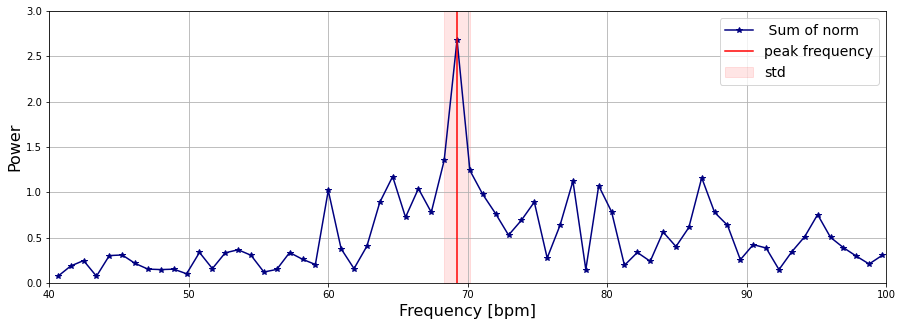

In [25]:
fig7, ax7 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 5 ) )
ax7.plot( norm_freq*60 , norm_power[norm_mask] , '-*' , label = ' Sum of norm' , color = 'navy' )
ax7.axvline( fft_peak_freq*60 , color='red' , label = 'peak frequency')
ax7.fill_betweenx( y=[ 0 , 3 ] , x1 = (fft_peak_freq-fft_err_peak_freq)*60 , 
                   x2 = (fft_peak_freq+fft_err_peak_freq)*60 , 
                   color = 'red' , alpha = 0.1 , label = 'std' )
ax7.set_xlim( down_freq_lim*60 , up_freq_lim*60 )
ax7.set_ylim( 0 , 3 )
ax7.set_xlabel( 'Frequency [bpm]' , fontsize = 16 )
ax7.set_ylabel( 'Power' , fontsize = 16 )
ax7.legend( loc = 'upper right' , fontsize = 14 )
ax7.grid()
plt.show()

### 2.3 **Filtering signal with FFT**

The Inverse Fourier Transform is then applied to the specific range of frequencies selected in the previous section. The output signal to this procedure is clearer and smoother compare to the original signal (in input to the direct Fourier Transform) and can be used independently of the HR estimation.

In [26]:
def filtered_power( vect_fft , vect_all_freq , down_freq_lim , up_freq_lim ):
    vect_filtered_fft = vect_fft.copy()
    vect_filtered_fft[ np.abs(vect_all_freq) >= up_freq_lim ] = 0
    vect_filtered_fft[ np.abs(vect_all_freq) <= down_freq_lim ] = 0
    vect_filtered = ( fftpack.ifft( vect_filtered_fft ) ).real
    return vect_filtered

norm_filtered = filtered_power( norm_fft , norm_all_freq , down_freq_lim , up_freq_lim )

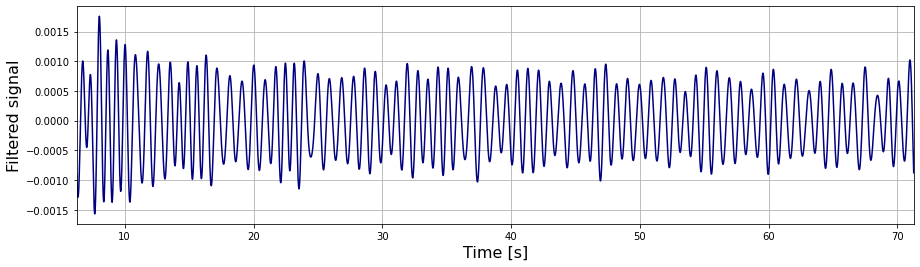

In [27]:
fig8 , ax8 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 4 ) )
ax8.plot(to_analyze['Time'] , norm_filtered , '-' , label = 'norm' , color = 'navy' )
ax8.set_xlim(min(to_analyze['Time']), max(to_analyze['Time']) )
ax8.set_xlabel( 'Time [s]' , fontsize = 16 )
ax8.set_ylabel( 'Filtered signal' , fontsize = 16 )
#ax8.legend( loc = 'upper right' , ncol = 2 , fontsize = 14 )
ax8.grid()
plt.show()

## 3. **Heart-rate estimation through Wavelet transform**

In this section, the band-pass filtered signal will be processed further with wavelet transform. 

Wavelet transform is a tool to deconstruct signal into its corresponding frequency components along with the time evolution. The temporal information given by this method is an advantage over FFT transformation and allows to estimate Heart Rate Variability (HRV).

Wavelet transform can be divided into two main categories based on the wavelets: discrete wavelet transforms and continous wavelet transforms. 

### 3.1 **Discrete Wavelet Transform**

The reverse biorthogonal 3.9 (rbio3.9) discrete wavelet is chosen to decompose the band-pass filtered signal. The choice of the wavelet was based on other studies [3].

In [28]:
Image("rbio3.9.png")

NameError: name 'Image' is not defined

As seen in the <a href="https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html"> <code>pywt.wavelet</code></a> documentation, the discrete wavelet takes other inputs such as the level of deconstruction, which was set to <code>level=6</code> after some tuning. Afterwards, the unnecessary coefficients were discarded by setting them to 0.


In [ ]:
def dwt(time, vect, level):
    i = level+1
    coef = pywt.wavedec(vect , 'rbio3.9', level=i )

    for k in range (i):
        if (k != 1)&(k != 2): 
            coef[k] = np.zeros(coef[k].shape)
    dwt_sig = pywt.waverec( coef, 'rbio3.9' )
    
    fig9 , ax9 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 4 ) )
    ax9.plot(time, dwt_sig[:-1])
    ax9.set_xlim(min(time),max(time))
    ax9.set_xlabel ("Time [s]", fontsize=16)
    ax9.set_ylabel ("Magnitude freq [Hz]", fontsize=16)
    return dwt_sig

In [ ]:
dwt_sig = dwt( time, norm_filtered , 6)

The temporal information in output to <code>dwt</code> is then analyzed: its peaks are identified to calculate the intervals between one another.

In [ ]:
def peaks(time, vect):
    peaks, _ = signal.find_peaks(vect, width = 50) 
    
    num_peak = len(peaks)
    t  = time.max() - time.min()
    bps = num_peak/t
    print('BPM is', bps*60)

    plt.figure( figsize = ( 15 , 4 ) )
    plt.plot(time,vect[:-1])
    plt.plot(time[peaks], vect[peaks], "x")
    plt.xlim(min(time),max(time))
    plt.xlabel ("Time [s]", fontsize=16)
    plt.ylabel ("Magnitude freq [Hz]", fontsize=16)
    return (peaks)


In [ ]:
peak = peaks( to_analyze['Time'], dwt_sig)

Below are the functions that are used for fitting.

In [ ]:
def Gauss(x,A,mu,sigma):
    return A*np.exp(-(x - mu)**2/(2 * sigma**2)) 

def Cauchy(x,A,t,s):
    return A/(s*np.pi*(1 + ((x-t)/s)**2 ))

def Log_Logistics(x,A,a,b):
    return A*(b/a)*(x/a)**(b-1)/(1 + (x/a)**b)**2

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = ( 15 , 5 ) )

# histogram and fit of HRV
times = np.asarray(time)
hrv = times[peak[1:]] - times[peak[:-1]] 
value_hrv, bins_hrv, _  = ax[0].hist(hrv,bins='auto', density = True,  stacked = True,
                                     color ='lightblue', ec = 'navy')
bins_mean_hrv=(bins_hrv[:-1]+bins_hrv[1:])/2
xspace_hrv = np.linspace(0.6,1.1,100)

opt_gauss_hrv, cov_gauss_hrv = curve_fit(Gauss, xdata=bins_mean_hrv, ydata=value_hrv, p0=[16, 0.85, 0.1])
print('Gaussian', opt_gauss_hrv, np.sqrt(np.diag(cov_gauss_hrv)))
opt_cauchy, cov_cauchy = curve_fit(Cauchy, xdata=bins_mean_hrv, ydata=value_hrv, p0=[16, 0.85, 0.1])
print('Cauchy', opt_cauchy, np.sqrt(np.diag(cov_cauchy)))

ax[0].plot(xspace_hrv, Gauss(xspace_hrv, *opt_gauss_hrv), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
ax[0].plot(xspace_hrv, Cauchy(xspace_hrv, *opt_cauchy), color='purple', linewidth=2.5, label='Cauchy', alpha=0.65)
ax[0].set_xlabel('HRV [s]' , fontsize = 16)
ax[0].set_ylabel('Counts' , fontsize = 16)
ax[0].legend( fontsize = 14 ) 

    
# histogram and fit of BPM  
ffreq = 1/hrv
value_heart, bins_heart, _ = ax[1].hist(ffreq*60,bins='auto', density = True, stacked = True,
                                        color ='lightblue', ec = 'navy')
bins_mean_heart=(bins_heart[:-1]+bins_heart[1:])/2 
xspace_heart = np.linspace(56,90,100)

opt_gauss_heart, cov_gauss_heart = curve_fit(Gauss, xdata=bins_mean_heart, ydata=value_heart, p0=[0.07, 70, 5])
print('Gaussian', opt_gauss_heart, np.sqrt(np.diag(cov_gauss_heart)))
opt_log, cov_log = curve_fit(Log_Logistics, xdata=bins_mean_heart, ydata=value_heart, p0=[1, 70, 20])
print('Log', opt_log,np.sqrt(np.diag(cov_log)))

ax[1].plot(xspace_heart, Gauss(xspace_heart, *opt_gauss_heart), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
ax[1].plot(xspace_heart, Log_Logistics(xspace_heart, *opt_log), color='purple', linewidth=2.5, label='Log', alpha=0.65)
ax[1].set_xlabel('Heart rate [bpm]' , fontsize = 16)
ax[1].set_ylabel('Counts' , fontsize = 16)
ax[1].legend( fontsize = 14 )

- DWT selected HRV is from Cauchy distribution
- DWT selected HR is from Gaussian distribution

In [ ]:
dwt_peak_hrv = opt_cauchy[1]
dwt_peak_err_hrv = np.sqrt(np.diag(cov_cauchy))[1]
dwt_peak_hr = opt_gauss_heart[1]
dwt_peak_err_hr = np.sqrt(np.diag(cov_gauss_heart))[1]

### 3.2 **Continuous Wavelet Transform**

As seen in the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html"> <code>scipy.signal.find_peaks_cwt</code></a> documentation, the continuous wavelet takes inputs such as the potential width of the peaks, the type of wavelet (default: ricker) and the size of the window onto which the noise is calculated.


In [ ]:
def cwt(time, waves):
    peakind = signal.find_peaks_cwt(waves, np.arange(35,85), window_size = 20)
    temp = np.array(time[peakind])
    fig,ax = plt.subplots( figsize=(15,7) )
    ax.plot(time,waves,'-')
    ax.plot(temp, waves[peakind],'*')
    print(len(peakind),' peaks were found')
    print(len(peakind)/(time.max() - time.min())*60, 'BPM')
    return peakind

In [ ]:
temp = cwt(time,norm_filtered)

In [ ]:
fig2, ax2 = plt.subplots(ncols = 2, figsize = ( 15 , 5 ) )

# histogram and fit of HRV
times2 = np.asarray(time)
hrv2 = times2[temp[1:]] - times2[temp[:-1]] 
value_hrv2, bins_hrv2, _  = ax2[0].hist(hrv2,bins='auto', density = True,  stacked = True,
                                     color ='lightblue', ec = 'navy')
bins_mean_hrv2=(bins_hrv2[:-1]+bins_hrv2[1:])/2
xspace_hrv2 = np.linspace(0.6,1.1,100)

opt_gauss_hrv2, cov_gauss_hrv2 = curve_fit(Gauss, xdata=bins_mean_hrv2, ydata=value_hrv2, p0=[16, 0.85, 0.1])
print('Gaussian', opt_gauss_hrv2, np.sqrt(np.diag(cov_gauss_hrv2)))
opt_cauchy2, cov_cauchy2 = curve_fit(Cauchy, xdata=bins_mean_hrv2, ydata=value_hrv2, p0=[16, 0.85, 0.1])
print('Cauchy', opt_cauchy2, np.sqrt(np.diag(cov_cauchy2)))

ax2[0].plot(xspace_hrv2, Gauss(xspace_hrv2, *opt_gauss_hrv2), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
ax2[0].plot(xspace_hrv2, Cauchy(xspace_hrv2, *opt_cauchy2), color='purple', linewidth=2.5, label='Cauchy', alpha=0.65)
ax2[0].set_xlabel('HRV [s]' , fontsize = 16)
ax2[0].set_ylabel('Counts' , fontsize = 16)
ax2[0].legend( fontsize = 14 )

    
# histogram and fit of BPM  
ffreq2 = 1/hrv2
value_heart2, bins_heart2, _ = ax2[1].hist(ffreq2*60,bins='auto', density = True, stacked = True,
                                        color ='lightblue', ec = 'navy')
bins_mean_heart2=(bins_heart2[:-1]+bins_heart2[1:])/2 
xspace_heart2 = np.linspace(56,90,100)

opt_gauss_heart2, cov_gauss_heart2= curve_fit(Gauss, xdata=bins_mean_heart2, ydata=value_heart2, p0=[0.07, 70, 5])
print('Gaussian', opt_gauss_heart, np.sqrt(np.diag(cov_gauss_heart)))
opt_log2, cov_log2 = curve_fit(Log_Logistics, xdata=bins_mean_heart2, ydata=value_heart2, p0=[1, 70, 20])
print('Log', opt_log2,np.sqrt(np.diag(cov_log2)))

ax2[1].plot(xspace_heart2, Gauss(xspace_heart2, *opt_gauss_heart2), color='red', linewidth=2.5, label='Gaussian', alpha=0.65)
ax2[1].plot(xspace_heart2, Log_Logistics(xspace_heart2, *opt_log2), color='purple', linewidth=2.5, label='Log', alpha=0.65)
ax2[1].set_xlabel('Heart rate [bpm]' , fontsize = 16)
ax2[1].set_ylabel('Counts' , fontsize = 16)
ax2[1].legend( fontsize = 14 )

- CWT selected HRV is from Cauchy distribution
- CWT selected HR is from Gaussian distribution

In [ ]:
cwt_peak_hrv = opt_cauchy2[1]
cwt_peak_err_hrv = np.sqrt(np.diag(cov_cauchy2))[1]
dwt_peak_hr = opt_gauss_heart2[1]
dwt_peak_err_hr = np.sqrt(np.diag(cov_gauss_heart2))[1]

## 4. Respiratory rate estimation through FFT

The respiratory rate can be estimated through a similar strategy to the one presented in section 2.

The FFT-based algorithm selects a range of frequencies corresponding to the possible values of respiratory rate (9-25 breaths per minute). Then the respiratory rate is estimated as the local maxima, together with its error. 

In [ ]:
breath_down_freq_lim = 9/60
breath_up_freq_lim = 25/60

In [ ]:
figb1 , axb1 = plt.subplots( nrows = 1 , ncols = 1 , figsize = ( 15 , 3 ) )
axb1.plot( norm_all_freq , norm_power , '-' , label = ' Sum of norms ' , color = 'navy' )
axb1.fill_betweenx( y=[ 10**(-6) , 10**1 ] , x1 = breath_down_freq_lim , x2 = breath_up_freq_lim , color = 'forestgreen' , alpha = 0.3 , label = 'frequencies to keep' )
axb1.set_xlim(0, max( norm_all_freq ) )
axb1.set_ylim( 10**(-6) , 10**1 )
axb1.set_xlabel( 'Frequency [Hz]' , fontsize = 12 )
axb1.set_ylabel( 'Power' , fontsize = 12 )
axb1.set_yscale( 'log' )
axb1.legend( loc = 'upper right' , ncol = 2 , fontsize = 10 )
axb1.grid()
plt.show()

In [ ]:
# Adjust mask to freq of heart beat (9bpm and  25 bpm) translate it to sec

def breath_band_pass_filter(vect_all_freq, vect_power, breath_down_freq_lim , breath_up_freq_lim ):
    vect_mask = np.where( ( breath_down_freq_lim <= vect_all_freq ) & ( vect_all_freq <= breath_up_freq_lim ) )
    vect_freq = vect_all_freq [ vect_mask ]
    vect_peak_freq = vect_freq [ vect_power [ vect_mask ].argmax() ]
    vect_err_peak_freq = (vect_freq[(vect_power[vect_mask]).argmax() + 1]
                          - vect_freq[(vect_power[vect_mask]).argmax() - 1])/2
    return vect_mask , vect_freq , vect_peak_freq , vect_err_peak_freq

breath_mask, breath_freq, breath_peak_freq, breath_err_peak_freq = breath_band_pass_filter( norm_all_freq,
                                                                                              norm_power,
                                                                                              breath_down_freq_lim, 
                                                                                              breath_up_freq_lim)

print('the peak frequency estimated from the sum of norms is ', breath_peak_freq*60 ,' ± ',breath_err_peak_freq*60 ,' bpm')

In [ ]:
figb2, axb2 = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 4))

axb2.plot(breath_freq*60, norm_power[breath_mask] , '-*' , label = ' Sum of norm' , color = 'navy' )
axb2.axvline( breath_peak_freq*60 , color='red' , label = 'peak frequency')
axb2.fill_betweenx( y=[0, 1.4] , x1 = (breath_peak_freq-breath_err_peak_freq)*60 , 
                   x2 = (breath_peak_freq+breath_err_peak_freq)*60 , 
                   color = 'red' , alpha = 0.1 , label = 'std' )

axb2.set_xlim(breath_down_freq_lim*60, breath_up_freq_lim*60 )
axb2.set_ylim(0, 1.4)
axb2.set_xlabel('Frequency [bpm]', fontsize = 16)
axb2.set_ylabel('Power', fontsize = 16)
axb2.legend(loc = 'upper right' , fontsize = 14)
axb2.grid()
plt.show()

## 5. **Conclusions**

The Fast Fourier Transform (FFT) and wavelet methods implemented in this project give desirable results.  The FFT shows that the Heart Rate will be around:  69.24 ± 0.9  bpm. This value is in alignment with the limit of a healthy human heart rate (40 - 100 bpm). The final heart rate value obtained from wavelet processing also gives good results around 71.08 for both Continous Wavelet Transform (CWT) and Discrete Wavelet Transforms (DWT) and it fits nicely within the FFT estimated range. The heart rate variability in both wavelet methods fits with the Cauchy distribution and the heart rate measurement fits with the gaussian distribution. 

The FFT can be successfully extended to predict the range of respiratory rate, around 10.15  ±  0.9 bpm. This value is in the lower end of the respiratory rate (10 - 25 bpm) because the patient is presumably in relaxes supine state. 

In conclusion, FFT and wavelet methods applied are a successful approach to analysing heart rate, heart rate variability, and respiratory rate from SCG measurements.  